# Time series 
**adds an explicit order dependence between observations: a time dimension**

**Time dimension is both a constraint and a structure that provides a source of additional information**

**A time series is a sequence of observations taken sequentially in time**

***(ref. Time Series Analysis: Forecasting and Control (Wiley Series in Probability and Statistics))***

**Making predictions about the future is called extrapolation in the classical statistical handling of time series data**
**More modern fields focus on the topic and refer to it as time series forecasting. Forecasting involves taking models fit on historical data and using them to predict future observations**

Descriptive models can borrow for the future (i.e. to smooth or remove noise), they only seek to best describe the data. An important distinction in forecasting is that the future is completely unavailable and must only be estimated from what has already happened.

With timeseries we can work on data description or analysis and or on prediction. 

**In descriptive modeling, or time series analysis, a time series is modeled to determine its components in terms of seasonal patterns, trends, relation to external factors, and the like. In contrast, time series forecasting uses the information in a time series (perhaps with additional information) to forecast future values of that series**

***(ref. Practical Time Series Forecasting with R: A Hands-On Guide [2nd Edition] (Practical Analytics)***

## multi-step time series forecasting: strategies

### seperate models
prediction(t) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+1) = model2(obs(t),obs(t-1),obs(t-2),obs(t-3), ..., obs(t-n))


### recursive models 
prediction(t+1) = model(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model(prediction(t+1),obs(t),obs(t-1), ..., obs(t-n))

### Direct-Recursive Hybrid Strategies
prediction(t+1) = model1(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model2(prediction(t+1), obs(t), obs(t-1), ..., obs(t-n))

### Multiple output
prediction(t+1), prediction(t+2) = model(obs(t),obs(t-1), obs(t-2), ..., obs(t-n))

## Regression problem

**The forecasting problem is framed as a a regression problem, regression means that the output of model is a continus value. i.e. the goal is to predict the values of each time series in the moment t, by using the values of the previous moment (t-n, t-n+1, t-n+2, ...t-1)**

### univariate

If only one time series is used in the algorithm, it is called univariate forecasting

### multivariate

If multiple time series are used in the algorithm, it's called multivariate forecasting

## metrics note
Regression is done using different loss functions from classification; 
**Mean Squared Error (MSE)** is a commonly used loss function for regression.

**The root mean squared error (RMSE)** will be used as it punishes large errors and results in a score that is in the same units as the forecast data, 

In [2]:
# univariate data preparation
from numpy import array 
import numpy as np

import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

from math import sqrt
import math
from sklearn.metrics import mean_squared_error

# Model packages
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from keras.utils.vis_utils import plot_model

/home/qzhq7441/code/sckit-learn/hands-on-ml/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Discover and visualize the data

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
series = pd.read_csv('Daily_TSNew_i-001683a6-rp-static-server-15197471722.csv',index_col=[0])
series.head()

,cpu.percent
time,
2018-11-21 00:00:30,4.1
2018-11-21 00:01:00,4.5
2018-11-21 00:01:30,4.3
2018-11-21 00:02:00,4.4
2018-11-21 00:02:30,4.0


In [5]:
series.shape

(25911, 1)

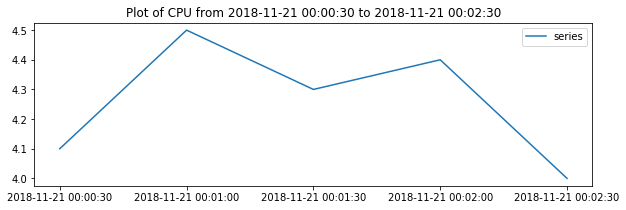

In [66]:
fig = plt.figure(figsize=(10,3))
plt.plot(series[:5], label="series")
plt.title('Plot of CPU from 2018-11-21 00:00:30 to 2018-11-21 00:02:30')
#plt.plot(series.values, label="series")
plt.legend(loc=0)

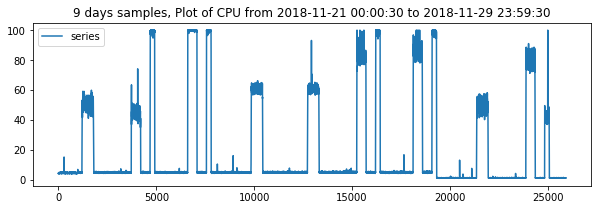

In [67]:
fig = plt.figure(figsize=(10,3))
#plt.plot(series[:100], label="series")
plt.title('9 days samples, Plot of CPU from 2018-11-21 00:00:30 to 2018-11-29 23:59:30')
plt.plot(series.values, label="series")
plt.legend(loc=0)

In [68]:
series = series.values
series.shape

(25911, 1)

# Preapre the data for machine Learning
   ## data split

In [70]:
from sklearn.preprocessing import MinMaxScaler
# split into train and test sets
train_size = int(len(series) * 0.67)
train, test = series[0:train_size,:], series[train_size:len(series),:]
train.shape, test.shape

((17360, 1), (8551, 1))

## data scale

In [73]:
def scale(train, test):
# fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
# transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
# transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# invert transform
#inverted_X = scaler.inverse_transform(scaled_X)
#inverted_series = Series(inverted_X[:, 0])
#print(inverted_series.head())

In [74]:
# scale data between -1 and 1 
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled, test_scaled
train = train_scaled
test = test_scaled

In [75]:
train

array([[-0.99583767],
       [-0.98751301],
       [-0.99167534],
       ...,
       [-0.98126951],
       [-0.98335068],
       [-0.97710718]])

In [76]:
test

array([[-0.97294485],
       [-0.98335068],
       [-0.97710718],
       ...,
       [-1.0603538 ],
       [-1.05619147],
       [-1.0603538 ]])

## construct the supervised-problem table
fig

In [77]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [91]:
# here we construct the supervised-problem table
lag= 3

#create training table for forecasting
trainseriesX, trainseriesy = split_sequence(train, lag)

#create testseriesX and testseriesy
testseriesX, testseriesy = split_sequence(test, lag)

trainseriesX.shape, testseriesX.shape


((17357, 3, 1), (8548, 3, 1))

    # Select and train the machine learning model

# LSTM model set up

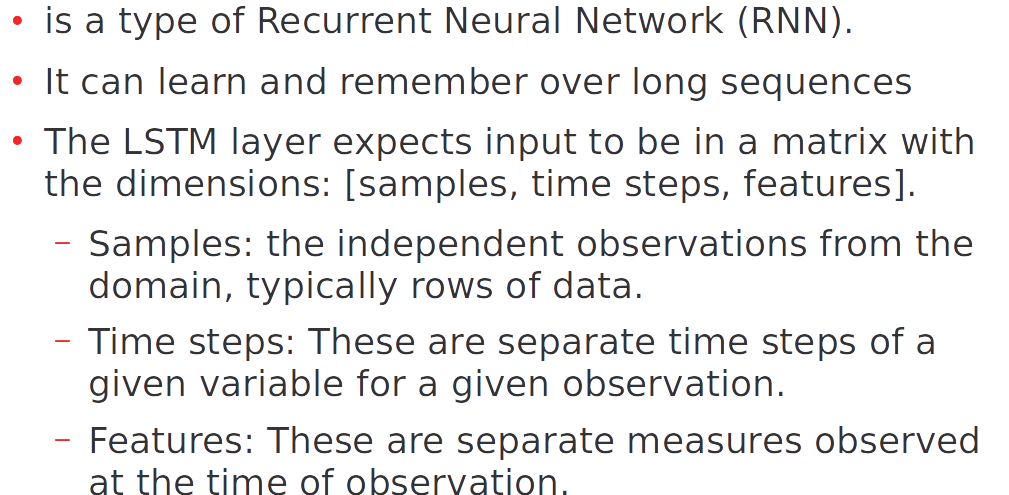

A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. 

In [105]:
# to always shape the data as [samples, timesteps, features]
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1

#seriesX = seriesX.reshape((seriesX.shape[0], seriesX.shape[1], n_features))
trainseriesX = trainseriesX.reshape((trainseriesX.shape[0], trainseriesX.shape[1], n_features))
# scenario1 config

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(lag, n_features)))
model.add(Dense(1))
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
model.summary()
plot_model(model, to_file='usecase2.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [106]:
sgd.get_config()

{'decay': 9.999999974752427e-07,
 'lr': 0.10000000149011612,
 'momentum': 0.8999999761581421,
 'nesterov': True}

# LSTM training

In [107]:
#repeats = 1
#error_trainscores = list()

#for r in range(repeats):
    # fit model
     
    #starting the training on trainseriesX with known trainseriesy
history = model.fit(trainseriesX, trainseriesy, epochs=2000, batch_size=40,verbose=1)
    
 

Epoch 1/2000
17357/17357 [==============================] - 2s 103us/step - loss: 0.1250 - mean_squared_error: 0.1250
Epoch 2/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/2000
17357/17357 [==============================] - 1s 71us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/2000
17357/17357 [==============================] - 1s 77us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 5/2000
17357/17357 [==============================] - 1s 76us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 6/2000
17357/17357 [==============================] - 1s 74us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 7/2000
17357/17357 [==============================] - 1s 76us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 8/2000
17357/17357 [==============================] - 1s 78us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 9/2000
17357/17357 [==============================] - 1s 

17357/17357 [==============================] - 1s 73us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 140/2000
17357/17357 [==============================] - 1s 73us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 141/2000
17357/17357 [==============================] - 1s 73us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 142/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 143/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 144/2000
17357/17357 [==============================] - 1s 82us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 145/2000
17357/17357 [==============================] - 1s 82us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 146/2000
17357/17357 [==============================] - 1s 86us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 147/2000
17357/17357 [==============================] - 1

Epoch 208/2000
17357/17357 [==============================] - 1s 74us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 209/2000
17357/17357 [==============================] - 1s 69us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 210/2000
17357/17357 [==============================] - 1s 75us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 211/2000
17357/17357 [==============================] - 1s 77us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 212/2000
17357/17357 [==============================] - 1s 75us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 213/2000
17357/17357 [==============================] - 1s 76us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 214/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 215/2000
17357/17357 [==============================] - 1s 75us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 216/2000
17357/17357 [====================

17357/17357 [==============================] - 1s 70us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 345/2000
17357/17357 [==============================] - 1s 77us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 346/2000
17357/17357 [==============================] - 1s 74us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 347/2000
17357/17357 [==============================] - 1s 75us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 348/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 349/2000
17357/17357 [==============================] - 1s 69us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 350/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 351/2000
17357/17357 [==============================] - 1s 73us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 352/2000
17357/17357 [==============================] - 1

17357/17357 [==============================] - 1s 74us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 481/2000
17357/17357 [==============================] - 1s 71us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 482/2000
17357/17357 [==============================] - 1s 74us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 483/2000
17357/17357 [==============================] - 1s 72us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 484/2000
17357/17357 [==============================] - 1s 70us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 485/2000
17357/17357 [==============================] - 1s 69us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 486/2000
17357/17357 [==============================] - 1s 71us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 487/2000
17357/17357 [==============================] - 1s 71us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 488/2000
17357/17357 [==============================] - 1

Epoch 617/2000
17357/17357 [==============================] - 1s 66us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 618/2000
17357/17357 [==============================] - 1s 67us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 619/2000
17357/17357 [==============================] - 1s 68us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 620/2000
17357/17357 [==============================] - 1s 70us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 621/2000
17357/17357 [==============================] - 1s 66us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 622/2000
17357/17357 [==============================] - 1s 67us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 623/2000
17357/17357 [==============================] - 1s 67us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 624/2000
17357/17357 [==============================] - 1s 68us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 625/2000
17357/17357 [====================

17357/17357 [==============================] - 1s 74us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 754/2000
17357/17357 [==============================] - 1s 77us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 755/2000
17357/17357 [==============================] - 1s 65us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 756/2000
17357/17357 [==============================] - 1s 62us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 757/2000
17357/17357 [==============================] - 1s 63us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 758/2000
17357/17357 [==============================] - 1s 63us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 759/2000
17357/17357 [==============================] - 1s 68us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 760/2000
17357/17357 [==============================] - 3s 150us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 761/2000
17357/17357 [==============================] - 

17357/17357 [==============================] - 4s 219us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 890/2000
17357/17357 [==============================] - 4s 203us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 891/2000
17357/17357 [==============================] - 4s 215us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 892/2000
17357/17357 [==============================] - 4s 216us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 893/2000
17357/17357 [==============================] - 4s 214us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 894/2000
17357/17357 [==============================] - 3s 194us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 895/2000
17357/17357 [==============================] - 4s 212us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 896/2000
17357/17357 [==============================] - 3s 196us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 897/2000
17357/17357 [===========================

17357/17357 [==============================] - 4s 203us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1026/2000
17357/17357 [==============================] - 4s 221us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1027/2000
17357/17357 [==============================] - 3s 167us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1028/2000
17357/17357 [==============================] - 3s 179us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1029/2000
17357/17357 [==============================] - 3s 177us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1030/2000
17357/17357 [==============================] - 3s 182us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1031/2000
17357/17357 [==============================] - 3s 184us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1032/2000
17357/17357 [==============================] - 3s 190us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1033/2000
17357/17357 [===================

17357/17357 [==============================] - 4s 207us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1160/2000
17357/17357 [==============================] - 3s 191us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1161/2000
17357/17357 [==============================] - 3s 202us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1162/2000
17357/17357 [==============================] - 3s 199us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1163/2000
17357/17357 [==============================] - 4s 206us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1164/2000
17357/17357 [==============================] - 4s 212us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1165/2000
17357/17357 [==============================] - 3s 165us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1166/2000
17357/17357 [==============================] - 4s 207us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1167/2000
17357/17357 [===================

17357/17357 [==============================] - 3s 183us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1294/2000
17357/17357 [==============================] - 3s 193us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1295/2000
17357/17357 [==============================] - 3s 197us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1296/2000
17357/17357 [==============================] - 4s 211us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1297/2000
17357/17357 [==============================] - 3s 182us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1298/2000
17357/17357 [==============================] - 3s 171us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1299/2000
17357/17357 [==============================] - 3s 167us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1300/2000
17357/17357 [==============================] - 3s 175us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1301/2000
17357/17357 [===================

17357/17357 [==============================] - 3s 179us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1428/2000
17357/17357 [==============================] - 3s 192us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1429/2000
17357/17357 [==============================] - 4s 203us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1430/2000
17357/17357 [==============================] - 3s 193us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1431/2000
17357/17357 [==============================] - 3s 192us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1432/2000
17357/17357 [==============================] - 4s 214us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1433/2000
17357/17357 [==============================] - 3s 190us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1434/2000
17357/17357 [==============================] - 3s 189us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1435/2000
17357/17357 [===================

17357/17357 [==============================] - 3s 196us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1562/2000
17357/17357 [==============================] - 4s 209us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1563/2000
17357/17357 [==============================] - 3s 182us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1564/2000
17357/17357 [==============================] - 4s 212us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1565/2000
17357/17357 [==============================] - 4s 217us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1566/2000
17357/17357 [==============================] - 3s 199us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1567/2000
17357/17357 [==============================] - 4s 219us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1568/2000
17357/17357 [==============================] - 3s 184us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1569/2000
17357/17357 [===================

17357/17357 [==============================] - 4s 205us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1696/2000
17357/17357 [==============================] - 3s 178us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1697/2000
17357/17357 [==============================] - 3s 185us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1698/2000
17357/17357 [==============================] - 3s 198us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1699/2000
17357/17357 [==============================] - 4s 202us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1700/2000
17357/17357 [==============================] - 3s 187us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1701/2000
17357/17357 [==============================] - 3s 199us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1702/2000
17357/17357 [==============================] - 3s 192us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1703/2000
17357/17357 [===================

17357/17357 [==============================] - 3s 190us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1830/2000
17357/17357 [==============================] - 3s 189us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1831/2000
17357/17357 [==============================] - 4s 205us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1832/2000
17357/17357 [==============================] - 3s 189us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1833/2000
17357/17357 [==============================] - 4s 206us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1834/2000
17357/17357 [==============================] - 4s 208us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1835/2000
17357/17357 [==============================] - 3s 186us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1836/2000
17357/17357 [==============================] - 3s 195us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1837/2000
17357/17357 [===================

17357/17357 [==============================] - 4s 210us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1964/2000
17357/17357 [==============================] - 3s 186us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1965/2000
17357/17357 [==============================] - 3s 196us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1966/2000
17357/17357 [==============================] - 3s 171us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1967/2000
17357/17357 [==============================] - 4s 209us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1968/2000
17357/17357 [==============================] - 3s 193us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1969/2000
17357/17357 [==============================] - 4s 205us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1970/2000
17357/17357 [==============================] - 4s 207us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1971/2000
17357/17357 [===================

# Model performance & Fine tuning

In [108]:
#perform the prediction on the train
trainPredict = model.predict(trainseriesX, batch_size=40, verbose =0)
    
    # calculate root mean squared error for train and test 
trainScore = math.sqrt(mean_squared_error(trainseriesy, trainPredict))
    #report performance for train
print('%d) Train RMSE: %.3f' % (r+1, trainScore))
    #error_trainscores.append(trainScore)

2) Train RMSE: 0.035


In [109]:
history.params
history.history['mean_squared_error']
history.model.metrics_names

['loss', 'mean_squared_error']

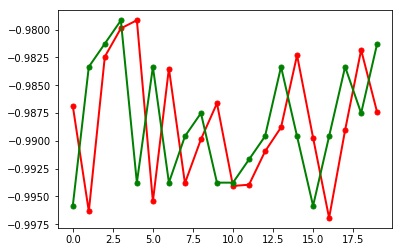

In [114]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(trainPredict[100:120], color='red', label='Predictedtrain', marker='o',linewidth=2,markersize=5)
ax.plot(trainseriesy[100:120], color='green', label='trueTrain', marker='o',linewidth=2,markersize=5)

In [115]:
testPredict= model.predict(testseriesX, batch_size=40, verbose =0)
# calculate root mean squared error for train and test 
testScore = math.sqrt(mean_squared_error(testseriesy,testPredict))
#report performance for train
print(testScore)


0.04349920079328738


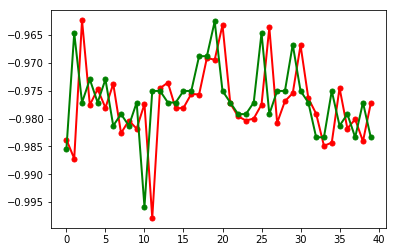

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(testPredict[110:150], color='red', label='Predictedtrain', marker='o',linewidth=2,markersize=5)
ax.plot(testseriesy[110:150], color='green', label='trueTrain', marker='o',linewidth=2,markersize=5)

ppt/ with all results with graphs 
model.evaluate('')